In [1]:
import pandas as pd
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import random
from sklearn.preprocessing import MinMaxScaler
random.seed(42)  # Set a seed value for reproducibility

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 

# Using relative paths
dfDeliveries = pd.read_csv("ball_by_ball.csv", low_memory=False)
dfDeliveries['calculated_ball'] = dfDeliveries['overs'] * 6 + dfDeliveries['ballnumber']
dfbatting = pd.read_csv("all_bat.csv")
dfbowling = pd.read_csv("all_bowl.csv")
dfvenue = pd.read_csv("venue.csv")
dfplayervsplayer = pd.read_csv("pvp_all.csv")
dfball_venue=pd.read_csv("venue_ballnumber.csv")
dfbatter_over=pd.read_csv("batterbyover.csv")
dfbowler_over=pd.read_csv("bowlerbyover.csv")

In [2]:
dfball_venue.columns

Index(['Venue', 'Ball_Number', '0', '1', '2', '3', '4', '5', '6', 'Wickets',
       'TotalBalls'],
      dtype='object')

In [3]:
class Player:
    def __init__(self, name, player_type= None):
        self.name = name
        self.player_type = player_type
    def __str__(self):
        return f"Player Name: {self.name}, Type: {self.player_type}"
class Batsman(Player):
    instances = []

    def __init__(self, name, dfDeliveries, team, consistency_score=1.0, **kwargs):
        super().__init__(name, "batsman")
        self.team = team
        self.consistency_score = consistency_score
        # Batsman-specific performance attributes and phase attributes initialization
        # Skipped for brevity
        self.active_ratio_death = kwargs.get('Active Ratio_death')
        self.striking_ratio_death = kwargs.get('Striking Ratio_death')
        self.true_sr_death = kwargs.get('True SR_death')
        self.true_avg_death = kwargs.get('True Avg_death')
        self.active_ratio_middle = kwargs.get('Active Ratio_middle')
        self.striking_ratio_middle = kwargs.get('Striking Ratio_middle')
        self.true_sr_middle = kwargs.get('True SR_middle')
        self.true_avg_middle = kwargs.get('True Avg_middle')
        self.active_ratio_powerplay = kwargs.get('Active Ratio_powerplay')
        self.striking_ratio_powerplay = kwargs.get('Striking Ratio_powerplay')
        self.true_sr_powerplay = kwargs.get('True SR_powerplay')
        self.true_avg_powerplay = kwargs.get('True Avg_powerplay')
        self.dfDeliveries = dfDeliveries[dfDeliveries['batter'] == self.name]
        self.dfData = dfbatter_over[dfbatter_over['BatterName'] == self.name]
        Batsman.instances.append(self)
        self.phase_attributes = {
            'powerplay': {},
            'middle': {},
            'death': {}
        }
        for phase in self.phase_attributes:
            for key, value in kwargs.items():
                if key.lower().endswith(phase):
                    self.phase_attributes[phase][key] = value
        
        #Batsman.instances.append(self)
    
    def get_phase_modifier(self, phase):
        attributes = self.phase_attributes.get(phase, {})
        if not attributes:
            return 1  # Default modifier if phase is not recognized
        modifier = sum(attributes.values()) / len(attributes)
        return modifier
    
    # Other methods skipped for brevity

    def calculate_probabilities(self, over_number):
        """
        Calculate base probabilities for this batsman in a given over from the DataFrame.
        
        :param over_number: The over number (1-20 in T20 cricket).
        
        :return: A dictionary with probabilities for each scoring outcome or a message if no data available.
        """
        # Filter the DataFrame for the given over number
        batsman_data = self.dfData[self.dfData['OverNo'] == over_number]
        
        if batsman_data.empty:
            return {}
        
        # Calculate probabilities
        probabilities = {}
        outcomes = ['Dot', '1', '2', '3', '4', '5', '6', 'Wickets']
        total_balls = batsman_data['TotalBalls'].iloc[0] if not batsman_data.empty else 0
        
        for outcome in outcomes:
            if total_balls > 0:
                probabilities[outcome] = batsman_data[outcome].iloc[0] / total_balls
            else:
                probabilities[outcome] = 0
        
        return probabilities

class Bowler(Player):
    instances = []

    def __init__(self, name, dfDeliveries, team, consistency_score=1.0, **kwargs):
        super().__init__(name, "bowler")
        self.team = team
        self.consistency_score = consistency_score
        self.dfDeliveries = dfDeliveries[dfDeliveries['bowler'] == self.name]
        self.dfData = dfbowler_over[dfbowler_over['BowlerName'] == self.name]  # Assuming dfDeliveries contains all necessary data
        # Bowler-specific performance attributes initialization
        # Skipped for brevity
        self.true_economy_death = kwargs.get('True Economy_death')
        self.true_sr_death = kwargs.get('True SR_death')
        self.dot_percentage_death = kwargs.get('dotpercentage_death')
        self.containment_death = kwargs.get('Containment_death')
        self.true_economy_middle = kwargs.get('True Economy_middle')
        self.true_sr_middle = kwargs.get('True SR_middle')
        self.dot_percentage_middle = kwargs.get('dotpercentage_middle')
        self.containment_middle = kwargs.get('Containment_middle')
        self.true_economy_powerplay = kwargs.get('True Economy_powerplay')
        self.true_sr_powerplay = kwargs.get('True SR_powerplay')
        self.dot_percentage_powerplay = kwargs.get('dotpercentage_powerplay')
        self.containment_powerplay = kwargs.get('Containment_powerplay')
        self.dfData = dfbowler_over[dfbowler_over['BowlerName'] == self.name]

        # Initialize phase attributes based on kwargs
        self.phase_attributes = {
            'powerplay': {},
            'middle': {},
            'death': {}
        }
        for phase in self.phase_attributes:
            for key, value in kwargs.items():
                if key.lower().endswith(phase):
                    self.phase_attributes[phase][key] = value

        Bowler.instances.append(self)

    def get_phase_modifier(self, phase):
        attributes = self.phase_attributes.get(phase, {})
        if not attributes:
            return 1  # Default modifier if phase is not recognized
        modifier = sum(attributes.values()) / len(attributes)
        return modifier

        Bowler.instances.append(self)
    
    # Other methods skipped for brevity

    def calculate_probabilities(self, over_number):
        """
        Calculate base probabilities for this bowler in a given over from the DataFrame.
        
        :param over_number: The over number (1-20 in T20 cricket).
        
        :return: A dictionary with probabilities for each scoring outcome or a message if no data available.
        """
        # Filter the DataFrame for the given over number
        bowler_data = self.dfData[self.dfData['OverNo'] == over_number]
        
        if bowler_data.empty:
            return {}
        
        # Calculate probabilities
        probabilities = {}
        outcomes = ['Dot', '1', '2', '3', '4', '5', '6', 'Wickets']
        total_balls = bowler_data['TotalBalls'].iloc[0] if not bowler_data.empty else 0
        
        for outcome in outcomes:
            if total_balls > 0:
                probabilities[outcome] = bowler_data[outcome].iloc[0] / total_balls
            else:
                probabilities[outcome] = 0
        
        return probabilities

class Venue:
    instances = []
    
    def __init__(self, venue_name, matches, total_run, dot_balls, is_wicket_delivery, delivery, fours, sixes, average_score, dot_ball_percentage, average_wickets_fallen, boundary_frequency, dfDeliveries):
        self.venue_name = venue_name
        self.matches = matches
        self.total_run = total_run
        self.dot_balls = dot_balls
        self.is_wicket_delivery = is_wicket_delivery
        self.delivery = delivery
        self.fours = fours
        self.sixes = sixes
        self.average_score = average_score
        self.dot_ball_percentage = dot_ball_percentage
        self.average_wickets_fallen = average_wickets_fallen
        self.boundary_frequency = boundary_frequency
        self.pitch_condition_factor = self.calculate_pitch_factor()  
        self.instances.append(self)
        self.dfDeliveries = dfDeliveries[dfDeliveries['Venue'] == self.venue_name]

        self.dfData = dfball_venue[dfball_venue['Venue'] == self.venue_name]  # Assuming dfDeliveries is the correct DataFrame to use here

    def calculate_pitch_factor(self):
        return self.average_score / 120

    @classmethod
    def print_all_instances(cls):
        for instance in cls.instances:
            print(f"{instance.venue_name}: Pitch Condition Factor = {instance.pitch_condition_factor}")
            
    def venue_base_probabilities(self, over_number, ball_number=None):
        # Ensure 'Ball_Number' column exists
        # if 'Ball_Number' not in self.dfData.columns:
        #     self.dfData['Ball_Number'] = (self.dfData['overs'] - 1) * 6 + self.dfData['ball_in_over']  # Adjust column names as necessary

        # Calculate the ball_number if not provided
        if ball_number is None:
            ball_number = (over_number ) * 6 + 1  # Assuming over_number starts at 1 and 6 balls per over

        # Filter for the specific ball_number
        ball_data = self.dfData[self.dfData['Ball_Number'] == ball_number]

        if ball_data.empty:
            return {} 

        # Calculate probabilities
        probabilities = {}
        outcomes = ['0', '1', '2', '3', '4', '5', '6', 'Wickets']
        total_balls = ball_data['TotalBalls'].iloc[0] if not ball_data.empty else 0

        for outcome in outcomes:
            probabilities[outcome] = ball_data[outcome].iloc[0] / total_balls if total_balls > 0 else 0

        return probabilities



def get_venue_features(dfvenue, dfDeliveries, venue_name):
    # Filter the dataframe for the given venue_name
    venue_data = dfvenue[dfvenue['venue_name'] == venue_name].iloc[0]
    
    # Assuming dfDeliveries contains delivery information for all venues,
    # filter it for the current venue
    venue_deliveries = dfDeliveries[dfDeliveries['Venue'] == venue_name]
    
    # Extract features from the filtered dataframe row and create Venue object
    venue = Venue(
        venue_name=venue_data['venue_name'],
        matches=venue_data['Matches'],
        total_run=venue_data['total_run'],
        dot_balls=venue_data['Dot_Balls'],
        is_wicket_delivery=venue_data['isWicketDelivery'],
        delivery=venue_data['delivery'],
        fours=venue_data['Fours'],
        sixes=venue_data['Sixes'],
        average_score=venue_data['Average Score'],
        dot_ball_percentage=venue_data['Dot Ball Percentage'],
        average_wickets_fallen=venue_data['Average Wickets Fallen'],
        boundary_frequency=venue_data['Boundary Frequency'],
        dfDeliveries=venue_deliveries  # Pass the filtered deliveries DataFrame
    )
    
    return venue



def get_player_all_profiles(playing_xi_team, dfbatting, dfbowling):
    # Initialize empty dicts to hold player profiles
    player_profiles = {}
    
    # Search and Extract Profiles for Both Batting and Bowling
    for team, player_list in playing_xi_team.items():
        for player in player_list:
            player_profiles[player] = {
                'batting': None,
                'bowling': None
            }

            # Check batting stats
            if player in dfbatting['batter'].values:
                player_profiles[player]['batting'] = dfbatting[dfbatting['batter'] == player].to_dict('records')[0]

            # Check bowling stats
            if player in dfbowling['bowler'].values:
                player_profiles[player]['bowling'] = dfbowling[dfbowling['bowler'] == player].to_dict('records')[0]

    return player_profiles
class MatchDynamics:
    def __init__(self, current_run_rate=0.0, required_run_rate=8.5, wickets_left=1, overs_remaining=19, weather_condition="Ok", match_pressure="Medium", crowd_support="Neutral"):
        self.current_run_rate = current_run_rate
        self.required_run_rate = required_run_rate
        self.wickets_left = wickets_left
        self.overs_remaining = overs_remaining
        self.weather_condition = weather_condition
        self.match_pressure = match_pressure
        self.crowd_support = crowd_support

    def calculate_dynamics_probabilities(self):
        """
        Adjust probabilities based on match dynamics such as current and required run rates,
        weather conditions, match pressure, and crowd support.
        """
        adjustments = {}
        self.adjust_match_pressure() 

        # Adjustments based on run rates
        if self.required_run_rate is not None:  # Relevant in second innings
            rate_difference = self.required_run_rate - self.current_run_rate
            if rate_difference > 2:
                adjustments["pressure"] = "High"
            elif rate_difference < -2:
                adjustments["pressure"] = "Low"
            else:
                adjustments["pressure"] = "Medium"

        # Adjustments based on weather conditions
        if self.weather_condition == "Rainy":
            adjustments["batting_difficulty"] = 1.1  # Example: batting becomes 10% harder
        elif self.weather_condition == "Dew":
            adjustments["bowling_difficulty"] = 1.05 
            # Example: bowling becomes 5% harder
        elif self.weather_condition == "Ok":
            adjustments["bowling_difficulty"] = 1.0 
        
        # Adjustments based on match pressure
        if self.match_pressure == "High":
            adjustments["risk_factor"] = 1.12  # Players are more likely to take risks
        elif self.match_pressure == "Low":
            adjustments["risk_factor"] = 0.88  # Players are less likely to take risks

        # Adjustments based on crowd support
        if self.crowd_support == "Home":
            adjustments["morale_boost"] = 1.1  # Home team gets a morale boost
        elif self.crowd_support == "Away":
            adjustments["morale_boost"] = 0.9  # Away team might be slightly demoralized
        
        return adjustments


    def _base_probabilities(self):
        """
        Defines the base probabilities without considering the dynamics.

        :return: A dictionary with base probabilities for scoring outcomes.
        """
        return {'0': 0.2, '1': 0.3, '2': 0.1, '3': 0.05, '4': 0.2, '5': 0.05, '6': 0.1, 'Wickets': 0.1}

    def _adjust_for_run_rate(self, probabilities):
        """
        Adjusts probabilities based on the required run rate and current run rate.

        :param probabilities: The current probabilities dictionary.
        :return: An adjusted probabilities dictionary.
        """
        # Example adjustment
        if self.required_run_rate > self.current_run_rate:
            probabilities['6'] += 0.05  # Increase the probability of hitting a six
            probabilities['0'] -= 0.05  # Decrease the probability of scoring no run
        return probabilities

    def _adjust_for_weather(self, probabilities):
        """
        Adjusts probabilities based on weather conditions.

        :param probabilities: The current probabilities dictionary.
        :return: An adjusted probabilities dictionary.
        """
        if self.weather_condition == "Rainy":
            probabilities['Wickets'] += 0.05  # Increase the chance of getting out
            probabilities['4'] -= 0.05  # Decrease the chance of hitting a four
        return probabilities

    def _adjust_for_pressure(self, probabilities):
        """
        Adjusts probabilities based on the match pressure.

        :param probabilities: The current probabilities dictionary.
        :return: An adjusted probabilities dictionary.
        """
        if self.match_pressure == "High":
            probabilities['Wickets'] += 0.1  # Increase the chance of getting out under high pressure
            probabilities['1'] -= 0.1  # Decrease the chance of taking singles
        return probabilities

    def adjust_match_pressure(self):
        """Adjust match pressure based on current run rate, required run rate, and wickets left."""
        if self.required_run_rate is None:
            self.match_pressure = "Medium"
            return

        rate_difference = self.required_run_rate - self.current_run_rate
        pressure_based_on_rate = "Medium"
        if rate_difference > 2:
            pressure_based_on_rate = "High"
        elif rate_difference < -2:
            pressure_based_on_rate = "Low"

        # Further adjust pressure based on wickets left (less wickets means higher pressure)
        if self.wickets_left <= 3:
            pressure = "High"
        elif self.wickets_left >= 7:
            pressure = "Low"
        else:
            pressure = pressure_based_on_rate

        # Consider adjusting for overs_remaining if needed
        # This is an example and can be fine-tuned according to your simulation needs.

        self.match_pressure = pressure

    # Additional methods such as _adjust_for_run_rate, _adjust_for_weather, _adjust_for_pressure...


numerical_cols_dfbatting = dfbatting.select_dtypes(include=['float64', 'int64']).columns
numerical_cols_dfbowling = dfbowling.select_dtypes(include=['float64', 'int64']).columns

# Normalize dfbatting
scaler = MinMaxScaler(feature_range=(-1, 1))
dfbatting[numerical_cols_dfbatting] = scaler.fit_transform(dfbatting[numerical_cols_dfbatting])

# Normalize dfbowling
dfbowling[numerical_cols_dfbowling] = scaler.fit_transform(dfbowling[numerical_cols_dfbowling])

def select_bowler(bowlers, phase):
    weights = {
        'Powerplay': {
            'true_economy_powerplay': 0.3,  # Higher is better
            'true_sr_powerplay': 0.35,  # Higher is better
            'dot_percentage_powerplay': 0.25,  # Higher is better
            'containment_powerplay': 0.1,  # Higher is better
        },
        'Middle Overs': {
            'true_economy_middle': 0.25,  # Higher is better
            'true_sr_middle': 0.2,  # Higher is better
            'dot_percentage_middle': 0.3,  # Higher is better
            'containment_middle': 0.25,  # Higher is better
        },
        'Death Overs': {
            'true_economy_death': 0.5,  # Higher is better
            'true_sr_death': 0.3,  # Higher is better
            'dot_percentage_death': 0.1,  # Higher is better
            'containment_death': 0.1,  # Higher is better
        }
    }
    
    phase_weights = weights[phase]
    
    def bowler_score(bowler):
        score = 0
        for attr, weight in phase_weights.items():
            stat = getattr(bowler, attr, 0)
            score += stat * weight  # Higher stats contribute more positively
        return score
    
    best_bowler = max(bowlers, key=bowler_score)
    return best_bowler

def select_batsman(batsmen, phase):
    weights = {
        'Powerplay': {
            'active_ratio_powerplay': 0.0,
            'striking_ratio_powerplay': 0.1,
            'true_sr_powerplay': 0.4,
            'true_avg_powerplay': 0.5,
        },
        'Middle Overs': {
            'active_ratio_middle': 0.1,
            'striking_ratio_middle': 0.1,
            'true_sr_middle': 0.4,
            'true_avg_middle': 0.4,
        },
        'Death Overs': {
            'active_ratio_death': 0.1,
            'striking_ratio_death': 0.15,
            'true_sr_death': 0.5,
            'true_avg_death': 0.25,
        }
    }
    
    phase_weights = weights[phase]
    
    def batsman_score(batsman):
        score = 0
        for attr, weight in phase_weights.items():
            stat = getattr(batsman, attr, 0)
            score += weight * stat
        return score
    
    best_batsman = max(batsmen, key=batsman_score)
    return best_batsman


def simulate_match(team1, team2, venue):
    # Correct variable names used for team rosters
    team1_batsmen = batsmen1
    team1_bowlers = bowlers1
    team2_batsmen = batsmen2
    team2_bowlers = bowlers2

    # Simulate the first innings
    team1_runs, team1_wickets, team1_ball_data = simulate_innings(team1_batsmen, team2_bowlers, venue, 1)
    print(f"Team 1 scored {team1_runs} for {team1_wickets} wickets.")

    # Simulate the second innings with an additional check for surpassing Team 1's score
    team2_runs, team2_wickets, team2_ball_data= simulate_innings(team2_batsmen, team1_bowlers, venue, 2, is_second_innings=True, target_runs=team1_runs + 1)
    print(f"Team 2 scored {team2_runs} for {team2_wickets} wickets.")

    # Determine the winner based on the scores
    if team1_runs > team2_runs:
        print(f"Team 1 wins by {team1_runs - team2_runs} runs.")
    elif team2_runs > team1_runs:
        print(f"Team 2 wins with {10 - team2_wickets} wickets remaining.")
    else:
        print("The match is a tie.")

    # Combine ball data from both innings and create DataFrame
    all_balls_data = team1_ball_data + team2_ball_data
    match_df = pd.DataFrame(all_balls_data)
    
    # This line is for demonstration. You may want to return, save, or process the DataFrame differently.
    return match_df

def print_ball_outcome(outcome_description):
    print(outcome_description)


def simulate_innings(batsmen, bowlers, venue, innings, total_overs=20, is_second_innings=False, target_runs=None):
    runs = 0
    wickets = 0
    all_balls_data = []
    all_probs_data = []
    last_bowler = None
    bowler_overs = {bowler.name: 0 for bowler in bowlers}

    # Initialize on-field and available batsmen
    on_field_batsmen = [batsmen[0], batsmen[1]]  # Start with the first two chosen batsmen
    available_batsmen = batsmen[2:]  # The rest are waiting

    striker_index = 0

    for over in range(total_overs):
        phase = "Powerplay" if over < 6 else "Middle Overs" if 6 <= over < 15 else "Death Overs"
        overs_completed = over if over > 0 else 1  # Avoid division by zero
        current_run_rate = runs / overs_completed
        required_run_rate = (target_runs - runs) / (total_overs - overs_completed) if target_runs else None
        
        # Select the best bowler for the current phase
        current_bowler = select_bowler([b for b in bowlers if b.name != last_bowler and bowler_overs[b.name] < 4], phase)
        last_bowler = current_bowler.name
        bowler_overs[current_bowler.name] += 1

        for ball in range(1, 7): 
            match_dynamics = MatchDynamics(current_run_rate=current_run_rate, 
                                           required_run_rate=required_run_rate, 
                                           wickets_left=10 - wickets, 
                                           overs_remaining=total_overs - over, 
                                           weather_condition="Ok", 
                                           match_pressure="Medium", 
                                           crowd_support="Neutral") # Each over consists of 6 legal deliveries
            if wickets >= 10 or (is_second_innings and runs >= target_runs):
                break  # All out or target achieved
            
            striker = on_field_batsmen[striker_index]
            ball_data, outcome_description = simulate_ball(striker, current_bowler, over, venue, match_dynamics)
            all_balls_data.append(ball_data)
            #all_probs_data.append(prob_data)
            
            runs += ball_data['batsman_run']
            wickets += ball_data['isWicketDelivery']
            
            if ball_data['isWicketDelivery']:
                if available_batsmen:
                    # Select the best available batsman after the fall of a wicket
                    best_next_batsman = select_batsman(available_batsmen, phase)
                    on_field_batsmen[striker_index] = best_next_batsman
                    available_batsmen.remove(best_next_batsman)
                else:
                    break  # No more batsmen to bat
            
            if ball_data['batsman_run'] % 2 != 0:
                striker_index = 1 - striker_index
        
        if ball == 6:  # Switch the strike at the end of the over
            striker_index = 1 - striker_index

    return runs, wickets, all_balls_data


def simulate_ball(batsman, bowler, over_number, venue, match_dynamics):
    assert isinstance(batsman, Batsman), "batsman is not an instance of Batsman"
    assert isinstance(bowler, Bowler), "bowler is not an instance of Bowler"
    assert isinstance(venue, Venue), "venue is not an instance of Venue"
    assert isinstance(match_dynamics, MatchDynamics), "match_dynamics is not an instance of MatchDynamics"
    
    # Calculate base probabilities from venue, batsman, and bowler
    venue_probs = venue.venue_base_probabilities(over_number)
    batsman_probs = batsman.calculate_probabilities(over_number)
    bowler_probs = bowler.calculate_probabilities(over_number)

    # Calculate adjustments based on match dynamics
    dynamics_adjustments = match_dynamics.calculate_dynamics_probabilities()

    # Base probabilities considering match dynamics
    base_probabilities = match_dynamics._base_probabilities()
    combined_probabilities = {}

    # Combine and adjust probabilities
    for outcome in base_probabilities.keys():
        venue_prob = venue_probs.get(outcome, base_probabilities[outcome])
        batsman_prob = batsman_probs.get(outcome, base_probabilities[outcome])
        bowler_prob = bowler_probs.get(outcome, base_probabilities[outcome])

        # Starting point for combination
        combined_prob = (venue_prob + batsman_prob + bowler_prob) / 3
        
        # Apply match dynamics adjustments here
        # Example: Adjusting for "batting_difficulty" and "bowling_difficulty"
        if outcome in ['4', '6']:  # Impactful hits like boundaries
            combined_prob *= dynamics_adjustments.get("batting_difficulty", 1.0)
        if outcome == 'Wickets':  # Wicket falling probability
            combined_prob *= dynamics_adjustments.get("bowling_difficulty", 1.0)

        # Adjusting based on match pressure (already calculated in MatchDynamics)
        # No explicit adjustment needed here if it's encapsulated in the dynamics calculations

        combined_probabilities[outcome] = np.clip(combined_prob, 0, 1)

    # Normalize combined probabilities
    total_prob = sum(combined_probabilities.values())
    normalized_probabilities = {outcome: prob / total_prob for outcome, prob in combined_probabilities.items()} if total_prob > 0 else {}

    if not normalized_probabilities:
        raise ValueError("Error in probability calculations.")

    # Select outcome based on normalized probabilities
    outcomes, probabilities = zip(*normalized_probabilities.items())
    selected_outcome = np.random.choice(outcomes, p=probabilities)

    # Constructing ball outcome data
    ball_data = {
        'batter': batsman.name,
        'bowler': bowler.name,
        'batsman_run': int(selected_outcome) if selected_outcome.isdigit() else 0,
        'extras_run': 0,
        'total_run': int(selected_outcome) if selected_outcome.isdigit() else 0,
        'non_boundary': 0 if selected_outcome in ['4', '6'] else 1,
        'isWicketDelivery': 1 if selected_outcome == 'Wickets' else 0,
        'player_out': batsman.name if selected_outcome == 'Wickets' else '',
        'BattingTeam': batsman.team,
        'Venue': venue.venue_name,
        'BowlingTeam': bowler.team,
    }

    outcome_description = f"{batsman.name} scores {selected_outcome} run(s) against {bowler.name}" if selected_outcome.isdigit() else f"{batsman.name} is out" if selected_outcome == 'Wickets' else f"{batsman.name} faces a dot ball against {bowler.name}"
    return ball_data, outcome_description


In [16]:
team1 = {
    'team_name': ["A Symonds", "AC Gilchrist","SR Watson","AD Russell","BA Stokes","CH Gayle","CH Morris","JC Archer","KA Pollard","KP Pietersen","Shakib Al Hasan"]
}
team2 = {
    'team_name': ["SR Tendulkar", "Z Khan","RG Sharma","V Kohli","MS Dhoni","KH Pandya","HH Pandya","JJ Bumrah","SK Raina","YK Pathan","YS Chahal"]
}
batsmen1 = []
bowlers1 = []
batsmen2 = []
bowlers2 = []
player_stats1 = get_player_all_profiles(team1,  dfbatting, dfbowling)
player_stats2 = get_player_all_profiles(team2,  dfbatting, dfbowling)
# Assuming dfDeliveries is already loaded and contains 'overs' and 'ballnumber' columns
dfDeliveries['calculated_ball'] = dfDeliveries['overs'] * 6 + dfDeliveries['ballnumber']

for player_name, stats in player_stats1.items():
    if 'batting' in stats and stats['batting'] is not None:
        batsmen1.append(Batsman(player_name,dfDeliveries ,team="Team 1",  **stats['batting']))
    if 'bowling' in stats and stats['bowling'] is not None:
        # Move dfDeliveries before the team keyword argument
        bowlers1.append(Bowler(player_name, dfDeliveries,"Team 1",  **stats['bowling']))

for player_name, stats in player_stats2.items():
    if 'batting' in stats and stats['batting'] is not None:
        batsmen2.append(Batsman(player_name, dfDeliveries,team="Team 2",  **stats['batting']))
    if 'bowling' in stats and stats['bowling'] is not None:
        # Move dfDeliveries before the team keyword argument
        bowlers2.append(Bowler(player_name, dfDeliveries, "Team 2", **stats['bowling']))


venue_name = "Brabourne Stadium"
venue1 = get_venue_features(dfvenue, dfDeliveries, venue_name)
# Create combined lists for batsmen and bowlers from both teams
all_batsmen = batsmen1 + batsmen2
all_bowlers = bowlers1 + bowlers2
# all_bowlers[0].dfData
# all_batsmen[0].dfData
# venue1.dfData
# Now call simulate_match with the combined lists
df1=simulate_match(team1, team2, venue1)
#simulate_match(team1,team2,venue1)
#df1
#df1.head(240)


Team 1 scored 162 for 5 wickets.
Team 2 scored 164 for 6 wickets.
Team 2 wins with 4 wickets remaining.


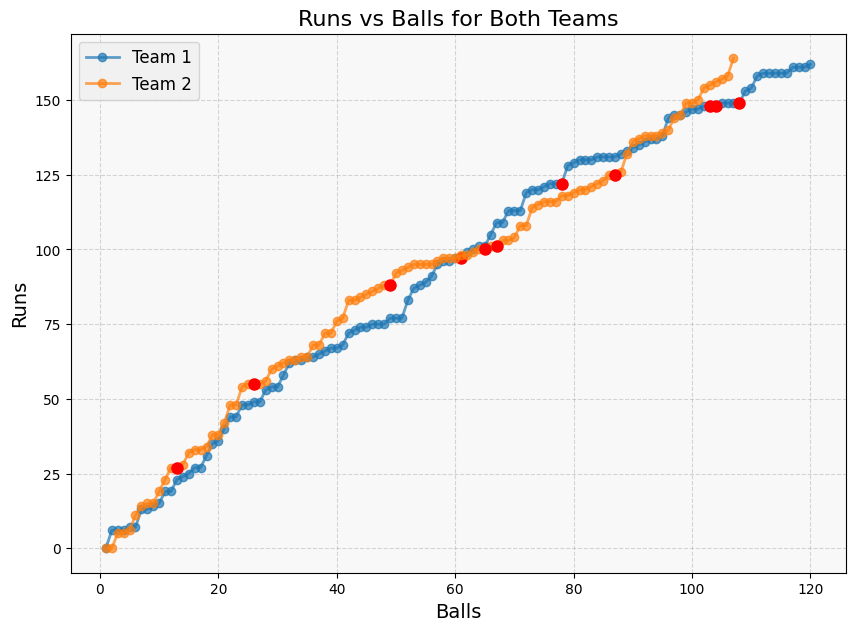

In [17]:
import matplotlib.pyplot as plt
df=df1
# Calculate cumulative runs for each team
df['cumulative_runs'] = df.groupby('BattingTeam')['batsman_run'].cumsum()

# Calculate ball count for each team (assuming each row is a ball played)
df['ball_number'] = df.groupby('BattingTeam').cumcount() + 1

# Adjust figsize for the desired plot dimensions
fig, ax = plt.subplots(figsize=(10, 7))

# Define color palette
colors = ['#1f77b4', '#ff7f0e']

for (team, group), color in zip(df.groupby('BattingTeam'), colors):
    # Plot cumulative runs vs. ball number for each team
    ax.plot(group['ball_number'], group['cumulative_runs'], label=team, 
            marker='o', linestyle='-', linewidth=2, markersize=6, alpha=0.7, color=color)

    # Corrected plotting of red dots for wickets
    # Filter for wicket deliveries in the group
    wickets = group[group['isWicketDelivery'] == 1]
    ax.plot(wickets['ball_number'], wickets['cumulative_runs'], 'ro', markersize=8)

# Set larger font sizes for readability
plt.rcParams.update({'font.size': 12})

# Add gridlines, labels, and title
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xlabel('Balls', fontsize=14)
ax.set_ylabel('Runs', fontsize=14)
ax.set_title('Runs vs Balls for Both Teams', fontsize=16)

# Enhance legend
ax.legend(fontsize=12, frameon=True, facecolor='#f0f0f0')
ax.set_facecolor('#f8f8f8')

plt.show()

